## Работа с датой

In [ ]:
# Сразу набор команд для создания фичей из timestamp
test['reviewTime_new'] = pd.to_datetime(test.unixReviewTime, unit='s')
train['review_year'] = pd.DatetimeIndex(train['review_time']).year
train['review_month'] = pd.DatetimeIndex(train['review_time']).month
train['review_day'] = pd.DatetimeIndex(train['review_time']).day
train['review_dayofweek'] = pd.DatetimeIndex(train['review_time']).dayofweek.astype(object)

## Инструменты для работы с колонками в датасете

In [ ]:
# Изменить порядок колонок
cols = ['review_dayofweek']  + [col for col in train if col != 'review_dayofweek']

## Создание новых признаков

In [ ]:
# Этот код выбирает числовые признаки, вычисляет их логарифмы, выбирает два категориальных признака,
# применяет к ним one-hot кодирование и объединяет оба множества в одно, а таже суммирует значения признаков между собой.

import itertools

def itr_combinations_new_features(data):
    
    tmp_df = data.copy()
    
    old_columns = [item for item in tmp_df.columns.tolist() if item != 'rating' and item != 'review_dayofweek' and item != 'userid']
    
    tmp_df_sum_2 = [(pd.Series(tmp_df.loc[:,list(i)].sum(axis=1),\
            name='_sum2_'.join(tmp_df.loc[:,list(i)].columns))) for i in list(itertools.combinations(old_columns,2))]
    
    tmp_df_sum_3 = [(pd.Series(tmp_df.loc[:,list(i)].sum(axis=1),\
            name='_sum3_'.join(tmp_df.loc[:,list(i)].columns))) for i in list(itertools.combinations(old_columns,3))]
    
    tmp_df_multiplication = [(pd.Series(tmp_df.loc[:,i[0]]*tmp_df.loc[:,i[1]],\
            name='_mult_'.join(tmp_df.loc[:,list(i)].columns))) for i in list(itertools.combinations(old_columns,2))]
    
   
    df_sum_2 = pd.DataFrame(tmp_df_sum_2).T  
    
    df_sum_3 = pd.DataFrame(tmp_df_sum_3).T  
    
    df_multiplication = pd.DataFrame(tmp_df_multiplication).T  
   
    data = pd.concat([data, df_sum_2, df_sum_3, df_multiplication], axis=1, sort=False)         
 
    
    return data


train_full = itr_combinations_new_features(train_full)

In [ ]:
# Функция для создания нового признака на базе группировки
def cat_age(x):
    if x == 1 : x = 1 # типа, если автомобилю 1 год, то добавим его в категорию 1
    elif 2 <= x < 4: x = 2 # типа, если автомобилю от 2 до 3 лет включительно, то добавим его в категорию 2 и тд.
    elif 4 <= x < 6: x = 3
    elif 6 <= x < 10: x = 4
    elif 10 <= x < 16: x = 5
    elif 16 <= x < 20: x = 6
    elif 20 <= x: x = 7
    return x 


test['car_age'] = test['car_age'].apply(lambda x: cat_age(x))

test['car_age'] = test['car_age'].astype('str')

In [ ]:
# Замена категориальных/бинарных на числовые
test['custom_clear'] = test['custom_clear'].apply(lambda x: "1" if x == "Растаможен" else "0").astype(int)

In [ ]:
# Замена по словарю
# словарь для кодировки
dic_body_type = {
    'внедорожник': 'allroad',
    'кабриолет': 'cabriolet',
    'компактвэн': 'compact_van',
    'купе': 'coupe',
    'лифтбек': 'liftback',
    'родстер': 'roadster',
    'седан': 'sedan',
    'универсал': 'station_wagon',
    'хэтчбек': 'hatchback'
}

test['body_type'] = test['body_type'].map(dic_body_type)

In [ ]:
# конъюнкция двух признаков
def make_conj(data, feature1, feature2):
    data['tmp_1'] = np.where(~data[feature2].str.contains('xDrive|Competition|sDrive|Package'),
                                 '', data[feature2])
    
    data['tmp_0'] = data[feature1]
    
    data['tmp'] = data['tmp_0'] + ' ' + data['tmp_1']
                    
    return (data)

# выполним корректировку названия
make_conj(name_tmp, 0, 1)

In [ ]:
# Напишем функцию, которая сделает полный список всех возможных фич в тестовой выборке.
def get_test_features(equipment):
    # Создаем пустой список, в который будут добавляться все фичи
    all_features = []
    for data in equipment:
        # Находим все слова между кавычками
        features=re.findall(r'\"(.+?)\"',data)
        # Добавляем в общий список
        all_features.extend(features)
    # Удаляем дубликаты
    all_features = list(dict.fromkeys(all_features))
    return all_features

test_features = get_test_features(test.equipment)

# Удаляем лишние записи
for bad_feature in ['name','Безопасность','values','Комфорт','Мультимедиа','Обзор','Салон','Защита от угона','Элементы экстерьера']:
    test_features.remove(bad_feature)    
print('Всего уникальных фич:', len(test_features))
print(test_features)

def get_features_test(equipment): 
    features=re.findall(r'\"(.+?)\"',equipment)  
    return features

In [ ]:
# Сделаем отбор фич с коэффициентом корреляции > 0.3
cor_target = abs(train_equipment.corr()["price"])
relevant_features = cor_target[cor_target>0.3] # Выбираем фичи с значением модуля коэффициента корреляции > 0.3
relevant_features

In [ ]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(etc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [ ]:
# Посмотрим вообще от каких признаков колеблется цена. Может там что-то интересного найду.
for c in new_train.columns[:-1]:
    plt.figure(figsize=(20,5))
    plt.title("{} vs. \nprice".format(c),fontsize=16)
    plt.scatter(x=new_train[c],y=new_train['price'],color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Стоимость', fontsize=14)

    plt.show()

In [ ]:
new_train_corr = new_train.corr()
new_train_corr

# new_train_corr.style.background_gradient(cmap='coolwarm')
new_train_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

# Create correlation matrix
corr_matrix = new_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)

# Drop features 
# new_big_df.drop(to_drop, axis=1, inplace=True)

In [ ]:
# Формирование dummy-столбцов
new_train_extend = pd.concat([new_train, 
                              pd.get_dummies(new_train['fuel_type'])], 
                             axis=1)

In [ ]:
# Сделаем dummies-преобразование на базе всех признаков из колонки

from tqdm import tqdm_notebook # для отображения динамики прогресса

def dummies_from_features_list(data, col, count, new_data):
    # Создаем пустой список, в который будут добавляться все доступные фичи во всей колонке
    all_features = []
    for item in data[col][:count]:
        # Находим все признаки для строки через разбивку
        features=item.split(',')
        # Добавляем в общий список
        all_features.extend(features)
    # Удаляем дубликаты
    all_features = list(dict.fromkeys(all_features))
    print(all_features)
    print(len(all_features))
    
    # А теперь сделаем dummies-преобразование
    for feature in tqdm_notebook(all_features):
        new_data[feature] = np.where(data[col].str.contains(feature), 1 ,0).astype(int) # более быстрый способ, чем через apply; если строка содержит название колонки, тогда в колонке поставим 1, иначе 0
#         new_data[feature] = data[col][:count].apply(lambda x: 1 if feature in x else 0).astype(int) # если строка содержит название колонки, тогда в колонке поставим 1, иначе 0
    

In [ ]:
# Еще один вариант дамми-преобразования
dummies_train = pd.get_dummies(new_train['PACK'], prefix = new_train['PACK'].name)

# Удаляем исходный столбец и добавляем dummies
new_train = new_train.drop(new_train['PACK'].name, axis=1).join(dummies_train)

In [ ]:
# Проводим dummies-колонки
# Функция для отображения фич в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0

# Создаем набор фич
col_list = [0, 1, 2]
for col in df_copy[col_list]:
    features = set()
    for featurelist in df_copy[col]:
        features.add(featurelist)

        # Cоздаем столбцы с фичами и заполняем 0 или 1
        for item in features:
            df_copy[item] = df_copy[col].apply(find_item)

df_copy = df_copy.drop(col_list, axis=1)

In [ ]:
# Сделаем dummies-преобразование на базе лучших признаков из списка

from tqdm import tqdm_notebook # для отображения динамики прогресса

def counter(data, col):
    #сольем все строчки, то есть все жанры в одну строку
    data_plot=data[col].str.cat(sep=',')
    #В пандасовский ряд соединим теперь все жанры
    dat=pd.Series(data_plot.split(','))
    #Посчитаем сколько жанров получается уникальных
    info=dat.value_counts(ascending=False)
    return info

sum_actors = counter(movies_database,'actors')

from collections import OrderedDict, defaultdict
    
def best_list(l):
    dict_from_list = l.to_dict()
    type(dict_from_list)

    best_list = []

    for key, value in dict_from_list.items():
        if value > 5:
            best_list.append(key)
            
    print(len(best_list))

    return best_list


best_actors = best_list(sum_actors)

def dummies_from_best_list(data, col, new_data, best_list):
   
    # Сделаем dummies-преобразование на базе лучших признаков из списка
    for feature in tqdm_notebook(best_list):
        new_data[feature] = np.where(data[col].str.contains(feature), 1 ,0).astype(int) # более быстрый способ, чем через apply; если строка содержит название колонки, тогда в колонке поставим 1, иначе 0    


## Split

In [ ]:
# Новый датафрейм с разбитыми данными из нужных мне колонки - сделаю так, чтобы это было решением не частным, а для всех случаев
body_type_tmp = test['body_type'].str.split(" ", n = 1, expand = True) 

## Выбросы

In [ ]:
# Сразу сделаю функцию для проверки и работе с выбросами
def outliers_iqr_short(ys):
    # Определяет номера значений с отклонением больше, чем iqr
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - 1.5*iqr
    upper_bound = quartile_3 + 1.5*iqr
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

def outliers_iqr_long(ys): # Передаем на вход признак-столбец датафрейма
    # Находим необходимые параметры
    median = ys.median()
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print('Медиана: {},'.format(median),'25-й перцентиль: {},'.format(quartile_1), '75-й перцентиль: {},'.format(quartile_3)
      , "IQR: {}, ".format(iqr),"Границы выбросов: [{}, {}].".format(lower_bound,upper_bound))
    # Отбрасываем значения, лежещие за пределами границ, рисуем график
#     ys.loc[ys.between(lower_bound, upper_bound)].hist(bins = int(upper_bound-lower_bound), range = (lower_bound, upper_bound), label = 'IQR')
#     plt.legend();
    # На выход отдаем отфильтрованные значения
    
    first_rec = ys.mask((ys > upper_bound) | (ys < lower_bound))
    second_rec = np.where((ys > upper_bound) | (ys < lower_bound))[0]
    
    return first_rec


In [1]:
# Функция очистки от выбросов
def delete_outliers_iqr(df, column):
    # Считаем первый и третий квартили
    first_quartile = df[column].describe()['25%']
    third_quartile = df[column].describe()['75%']

    # IQR (Межквартильный размах)
    iqr = third_quartile - first_quartile

    print(first_quartile, third_quartile, iqr)

    # Удаляем то, что выпадает за границы IQR
    #     df_tmp = df.copy()
    df = df[(df[column] > (first_quartile - 3 * iqr)) &
                (df[column] < (third_quartile + 3 * iqr))]

    df[column].hist()
    df[column].describe()

    df = df.loc[df[column].between(first_quartile - 1.5*iqr, third_quartile + 1.5*iqr)]
    df.info()

In [ ]:
Q1 =  new_train['price'].quantile(0.25)
Q3 = new_train['price'].quantile(0.75)
IQR = Q3 - Q1

new_train.query("@Q1 - 1.5*@IQR < price < @Q3 + 1.5*@IQR").boxplot(column="price")

In [ ]:
# Проверим на выбросы цены
fig = plt.figure(figsize=(7, 7))
plt.grid(True)
plt.title('Price')
sns.boxplot(x = new_train['price'])

In [ ]:
# Тепловая карта
sns.set(font_scale=1)
plt.subplots(figsize=(10, 10))
sns.heatmap(fuel_type_corr, square=True, 
           annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

## Мешок слов

In [ ]:
# Для создания мешка слов можно использовать такую функцию. Взял отсюда: https://www.kaggle.com/kishlaya18/netflix-movie-recommendation/data
def bag_of_word(data):

    data['bag_of_word'] = ''

    for index,row in data.iloc[:10].iterrows():

        plot = row['description']
        r = Rake()
        r.extract_keywords_from_text(plot)
        keyword_score = r.get_word_degrees()
        g = ' '.join(row['genres'].split(',')).lower()
        d = ' '.join(row['director'].split(',')).lower()
        a = ' '.join(row['actors'].split(',')).lower()
        k = ' '.join(list(keyword_score.keys()))
        
        data.loc[index, 'bag_of_word'] = g + ' ' + d + ' ' + a + ' ' + k # так для того, чтобы записать обратно в датафрейм

        print(row)

bag_of_word(full_available_now)


In [ ]:
# Более быстрый способ создания мешка слов. Быстрее раз в 100 по сравнению с предыдущим. Где-то прочитал, что через iterrows проходить по датафрейму не выгодно

def create_bag_of_word(x):
    return ' '.join(x['genres'].split(','))  + ' ' + ' '.join(x['director'].split(',')) + ' ' + ' '.join(x['actors'].split(','))

full_available_now['bag_of_word2'] = full_available_now.apply(create_bag_of_word, axis=1)

In [ ]:
# Превращение текстовых значений из датасета в мешок слов

# Для начала сгруппирую тексты из всех нужных столбцов в один (для каждой строчки)
def join_words(x):
    return ' '.join(str(x) for x in x[0:11])

df['bag_of_word'] = df.apply(join_words, axis=1)

# И дальше на базе этого нового созданного столбца создаю "мешок слов"

import re

def extract_words(sentence):
    words = sentence.split(' ')
    return words

def tokenize_sentences(sentences):
    words = []
    for sentence in sentences:
        w = extract_words(sentence)
        words.extend(w)
    words = sorted(list(set(words)))
    return words

def bagofwords(sentence, words):
    sentence_words = extract_words(sentence)
    # frequency word count
    bag = np.zeros(len(words))
    for sw in sentence_words:
        
        for i,word in enumerate(words):
            if word == sw: 
                bag[i] += 1
                
    return np.array(bag)

sentences = df['bag_of_word'].tolist()
vocabulary = tokenize_sentences(sentences)

data = []

for id, item in enumerate(sentences):
    data.append(bagofwords(item, vocabulary))
    
df_bags = pd.DataFrame(data, columns = vocabulary)

# Переведу созданные данные в int
df_bags = df_bags.astype(int)
df_bags

# Объединю новый датасет с мешком слов с базовым датасетом и удалю уже ненужные признаки
new_df = pd.concat([df, df_bags], axis=1)
new_df = new_df.drop(columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 'bag_of_word'])
new_df = new_df.rename(columns={12: 'target'})
new_df

# Все, теперь можно работать с датасетом как с мешком слов. Тот же Наивный Байес и тд.

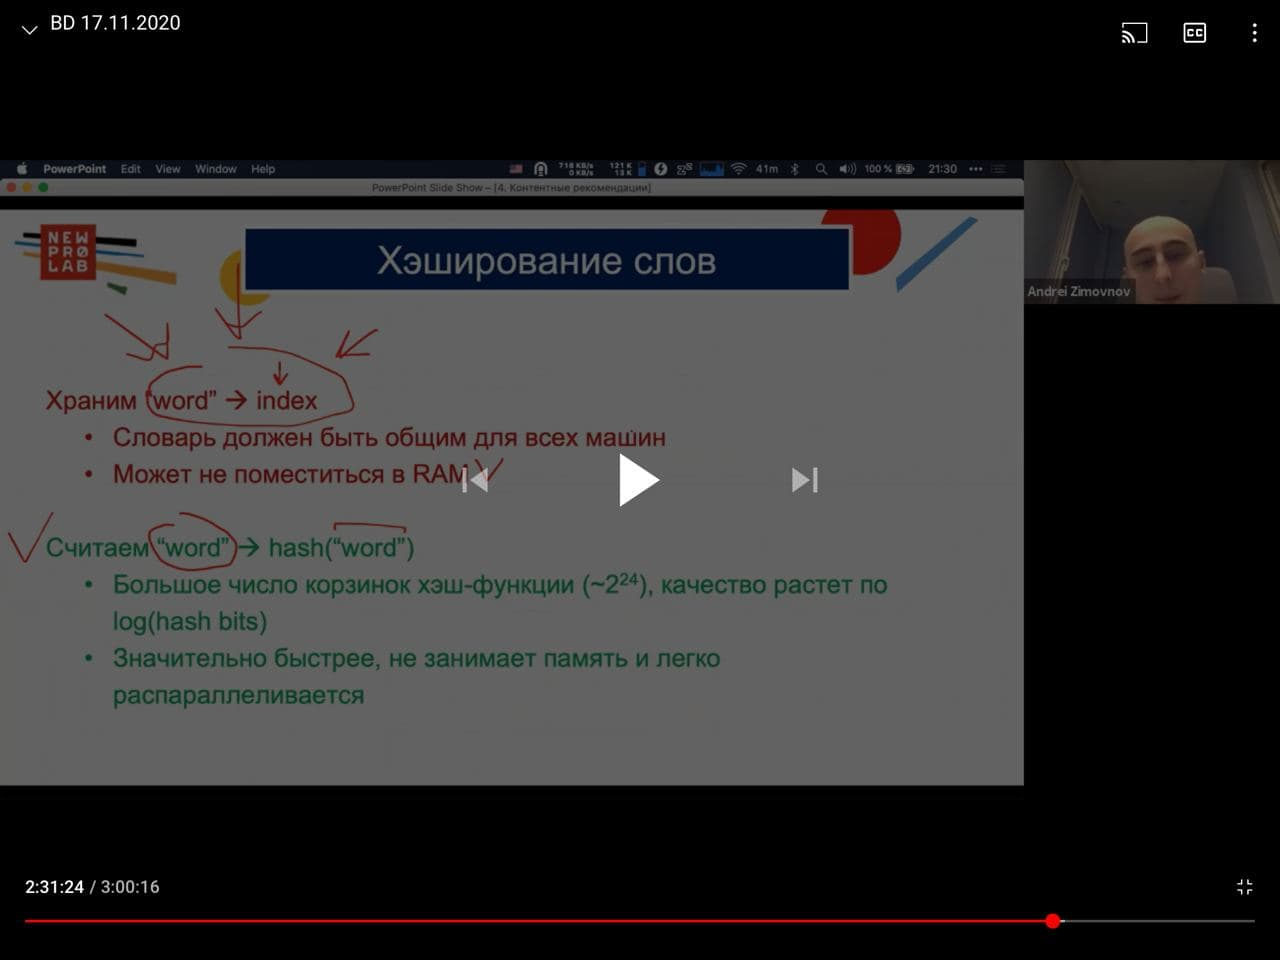

In [1]:
# Для больших данных сложно использовать прямое кодирование мешка слов - может не поместиться в RAM.
# Для этого используют хешинг. Например,

from sklearn.feature_extraction.text import HashingVectorizer
corpus = [
'This is the first document.',
'This document is the second document.',
'And this is the third one.',
'Is this the first document?',
]
vectorizer = HashingVectorizer(n_features=2**24)
X = vectorizer.fit_transform(corpus)
print(X)


  (0, 989160)	-0.4472135954999579
  (0, 3497392)	-0.4472135954999579
  (0, 4364366)	0.4472135954999579
  (0, 8533357)	0.4472135954999579
  (0, 8675486)	-0.4472135954999579
  (1, 544379)	0.35355339059327373
  (1, 3497392)	-0.7071067811865475
  (1, 4364366)	0.35355339059327373
  (1, 8533357)	0.35355339059327373
  (1, 8675486)	-0.35355339059327373
  (2, 4364366)	0.4082482904638631
  (2, 5423405)	-0.4082482904638631
  (2, 7239988)	-0.4082482904638631
  (2, 8533357)	0.4082482904638631
  (2, 8675486)	-0.4082482904638631
  (2, 15907589)	0.4082482904638631
  (3, 989160)	-0.4472135954999579
  (3, 3497392)	-0.4472135954999579
  (3, 4364366)	0.4472135954999579
  (3, 8533357)	0.4472135954999579
  (3, 8675486)	-0.4472135954999579


## Если нужно поработать со странами в фичах

In [ ]:
# Импорт библиотеки стран
import pycountry
import re

# Список стран
countries = [country.name.lower() for country in pycountry.countries]

# Уберем из названий в строках страны
for country in tqdm(countries):
    train.replace(re.compile(country), "", inplace=True)
    test.replace(re.compile(country), "", inplace=True)

## Простые метрики сходства строк - с помощью расстояния Ливенштейна

Преобразование с помощью расстояния Левенштейна

Непосредственно переходим к расстоянию Левеншейна. Небольшая справка: расстояние Левенштейна — минимальное количество операций вставки одного символа, удаления одного символа и замены одного символа на другой, необходимых для превращения одной строки в другую.

In [ ]:
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

levenshtein = Levenshtein()

train["levenstein"] = train.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
test["levenstein"] = test.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)

normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
test["norm_levenstein"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                              axis=1)

Еще можно использовать библиотеку fuzzywuzzy. Она помогает быстро и просто высчитать расстояние Левенштейна. Для ускорения работы авторы библиотеки советуют также установить библиотеку python-Levenshtein.

Попробую теперь другой способ - Cosine Similarity. https://towardsdatascience.com/calculating-string-similarity-in-python-276e18a7d33a Это дало рост оценки в 10 раз.

In [ ]:
import nltk
nltk.download('stopwords')

import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stopswords = stopwords.words(['arabic', 
 'azerbaijani', 
 'danish', 
 'dutch', 
 'english', 
 'finnish', 
 'french', 
 'german', 
 'greek',
 'hungarian', 
 'indonesian', 
 'italian', 
 'kazakh', 
 'nepali', 
 'norwegian', 
 'portuguese', 
 'romanian', 
 'russian', 
 'slovene', 
 'spanish', 
 'swedish', 
 'tajik', 
 'turkish'])
stoplist = set(stopwords.words(['arabic', 
 'azerbaijani', 
 'danish', 
 'dutch', 
 'english', 
 'finnish', 
 'french', 
 'german', 
 'greek',
 'hungarian', 
 'indonesian', 
 'italian', 
 'kazakh', 
 'nepali', 
 'norwegian', 
 'portuguese', 
 'romanian', 
 'russian', 
 'slovene', 
 'spanish', 
 'swedish', 
 'tajik', 
 'turkish']))

In [ ]:
def clean_string(text):
    text = ''.join([word for word in text if word not in string.punctuation])
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stoplist])

    return text

train_copy['cleaned_name_1'] = list(map(clean_string, train_copy.name_1))
train_copy['cleaned_name_2'] = list(map(clean_string, train_copy.name_2))

test_copy['cleaned_name_1'] = list(map(clean_string, test_copy.name_1))
test_copy['cleaned_name_2'] = list(map(clean_string, test_copy.name_2))

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer_1 = HashingVectorizer(n_features=2**4).fit_transform(train_copy['cleaned_name_1'])
train_copy['hashing_name_1'] = list(vectorizer_1.toarray())

vectorizer_2 = HashingVectorizer(n_features=2**4).fit_transform(train_copy['cleaned_name_2'])
train_copy['hashing_name_2'] = list(vectorizer_2.toarray())

vectorizer_1 = HashingVectorizer(n_features=2**4).fit_transform(test_copy['cleaned_name_1'])
test_copy['hashing_name_1'] = list(vectorizer_1.toarray())

vectorizer_2 = HashingVectorizer(n_features=2**4).fit_transform(test_copy['cleaned_name_2'])
test_copy['hashing_name_2'] = list(vectorizer_2.toarray())

In [ ]:
def cosine_sim_vectors(row):

    vec1 = row['hashing_name_1'].reshape(1, -1)
    vec2 = row['hashing_name_2'].reshape(1, -1)

    return cosine_similarity(vec1, vec2)[0][0]

from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())

from tqdm import tqdm
tqdm.pandas()

train_copy['cosine_sim'] = train_copy.apply(cosine_sim_vectors, axis=1)
test_copy['cosine_sim'] = test_copy.apply(cosine_sim_vectors, axis=1)

## Парсинг данных из ВКонтакте

In [ ]:
# https://habr.com/ru/post/478490/
import re
import time
import pandas as pd

import lp
import vk_api
import check_correctness


def auth():
    vk_session = vk_api.VkApi(lp.login, lp.password)
    vk_session.auth()
    vk = vk_session.get_api()
    return vk

def getDataFromComments(vk, groupID):

    #получаем последний пост в группе
    posts = vk.wall.get(owner_id=groupID, offset=1, count=90)
    print("\n")
    data = pd.DataFrame(columns=['text', 'post_id', "date", "day_in_week", "hour","minute", "day_in_month"])

    for post in posts.get("items"):
        #получаем id последнего поста в группе
        postID = post.get("id")

        if "Всем удачного дня, платите за проезд и не попадайтесь контролю" not in post.get("text"):
            continue

        #получаем объект commentary чтобы из него вытащить число комментариев
        comments = vk.wall.getComments(owner_id=groupID, post_id=postID, count=200)

        # проходимся по массиву комментариев и достаем всё что нужно в dataframe
        for comment in comments.get("items"):

            text = comment.get("text")
            text = re.sub(r"A-Za-zА-Яа-я0123456789 ", "", str(text))
            commentaryIsNice = check_correctness.detection(text)
            if commentaryIsNice:
                print(text)
                date = comment.get("date")
                time_struct = time.gmtime(date)
                post_id = comment.get("post_id")
                data = data.append({"text": text, "post_id" : post_id,
                                    "date": date,"day_in_week" : time_struct.tm_wday,
                                    "hour": (time_struct.tm_hour+3),
                                    "minute": time_struct.tm_min,
                                    "day_in_month": time_struct.tm_mday}, ignore_index=True)


    # print(data[:10])
    # print(data.info())

    print("dataset is ready")
    return data